In [ ]:
from google.colab import files
uploaded = files.upload()


Saving dataset.csv to dataset.csv


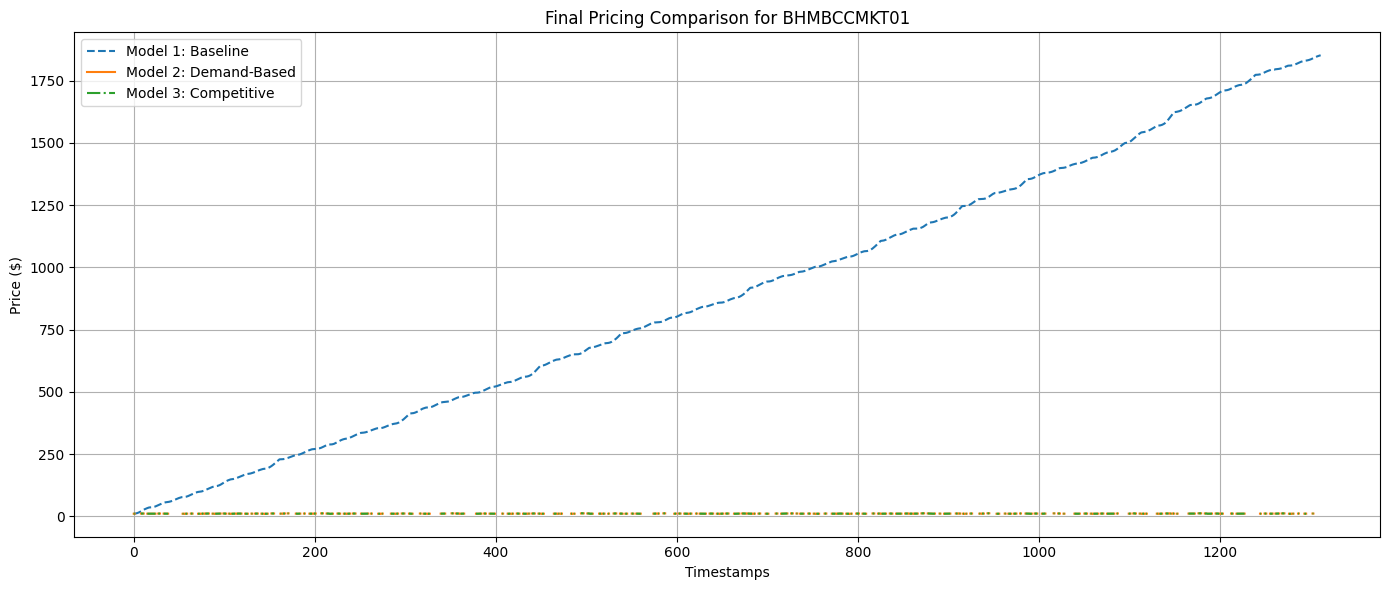

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic

df = pd.read_csv("dataset.csv")

base_price = 10
alpha = 5

df["OccupancyRatio"] = df["Occupancy"] / df["Capacity"]
df.sort_values(by=["SystemCodeNumber", "LastUpdatedDate", "LastUpdatedTime"], inplace=True)

prices = {}
for lot in df["SystemCodeNumber"].unique():
    lot_df = df[df["SystemCodeNumber"] == lot].copy()
    lot_prices = [base_price]
    for r in lot_df["OccupancyRatio"].iloc[1:]:
        lot_prices.append(lot_prices[-1] + alpha * r)
    prices[lot] = lot_prices

df["BaselinePrice"] = np.concatenate([prices[lot] for lot in df["SystemCodeNumber"].unique()])

traffic_map = {"low": 0, "moderate": 1, "high": 2}
vehicle_weight = {"bike": 0.5, "car": 1, "truck": 1.5}

df["TrafficLevel"] = df["TrafficConditionNearby"].map(traffic_map)
df["VehicleWeight"] = df["VehicleType"].map(vehicle_weight)

alpha_d, beta_d, gamma_d, delta_d, epsilon_d, lam = 2, 0.8, 1.2, 1.5, 1.0, 0.3

df["RawDemand"] = (
    alpha_d * df["OccupancyRatio"] +
    beta_d * df["QueueLength"] -
    gamma_d * df["TrafficLevel"] +
    delta_d * df["IsSpecialDay"] +
    epsilon_d * df["VehicleWeight"]
)

min_d, max_d = df["RawDemand"].min(), df["RawDemand"].max()
df["NormalizedDemand"] = (df["RawDemand"] - min_d) / (max_d - min_d)
df["Model2Price"] = base_price * (1 + lam * df["NormalizedDemand"])
df["Model2Price"] = df["Model2Price"].clip(lower=base_price*0.5, upper=base_price*2.0)

lots = df["SystemCodeNumber"].unique()
location_map = {
    lot: (df[df["SystemCodeNumber"] == lot]["Latitude"].iloc[0],
          df[df["SystemCodeNumber"] == lot]["Longitude"].iloc[0])
    for lot in lots
}

df["Timestamp"] = df["LastUpdatedDate"] + " " + df["LastUpdatedTime"]

target_lot = "BHMBCCMKT01"
target_location = location_map[target_lot]

distances = {
    other: geodesic(target_location, loc).meters
    for other, loc in location_map.items() if other != target_lot
}
nearby_lots = [k for k, v in distances.items() if v <= 1000]

target_df = df[df["SystemCodeNumber"] == target_lot].copy()
target_df.sort_values(by="Timestamp", inplace=True)
target_df.reset_index(drop=True, inplace=True)

adjusted_prices = []
for idx, row in target_df.iterrows():
    ts = row["Timestamp"]
    comp_df = df[(df["SystemCodeNumber"].isin(nearby_lots)) & (df["Timestamp"] == ts)]
    comp_prices = comp_df["Model2Price"]

    if not comp_prices.empty:
        avg_price = comp_prices.mean()
        if row["Occupancy"] >= row["Capacity"] * 0.95 and avg_price < row["Model2Price"]:
            new_price = avg_price * 0.95
        elif avg_price > row["Model2Price"] * 1.1:
            new_price = row["Model2Price"] * 1.1
        else:
            new_price = row["Model2Price"]
    else:
        new_price = row["Model2Price"]
    adjusted_prices.append(new_price)

target_df["Model3Price"] = adjusted_prices

plt.figure(figsize=(14, 6))
plt.plot(target_df["BaselinePrice"].values, label="Model 1: Baseline", linestyle="--")
plt.plot(target_df["Model2Price"].values, label="Model 2: Demand-Based")
plt.plot(target_df["Model3Price"].values, label="Model 3: Competitive", linestyle="-.")
plt.title(f"Final Pricing Comparison for {target_lot}")
plt.xlabel("Timestamps")
plt.ylabel("Price ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
